In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [17]:
from tensorflow_docs.vis import embed
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 25
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [5]:
train_data = pd.read_csv("../input/nnfl-2021-assignment-2/train.csv")
test_data = pd.read_csv("../input/nnfl-2021-assignment-2/test.csv")
print(f"Total videos for training: {len(train_data)}")
print(f"Total videos for testing: {len(test_data)}")
train_data.sample(10)

Total videos for training: 120
Total videos for testing: 20


,File,True_Label
116,2_60.avi,not_fire
16,1_24.avi,fire
72,2_20.avi,not_fire
52,1_57.avi,fire
55,1_6.avi,fire
10,1_19.avi,fire
64,2_13.avi,not_fire
35,1_41.avi,fire
101,2_47.avi,not_fire
68,2_17.avi,not_fire


In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=50, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [7]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")
feature_extractor = build_feature_extractor()
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_data["True_Label"])
)
print(label_processor.get_vocabulary())

2021-12-05 18:34:58.679006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:34:58.808150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:34:58.808837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:34:58.810112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step
['fire', 'not_fire']


In [8]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["File"].values.tolist()
    labels = df["True_Label"].values
    labels = label_processor(labels[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    return (frame_features, frame_masks), labels
data_train, labels_train = prepare_all_videos(train_data, "../input/nnfl-2021-assignment-2/train")
print(f"Frame features in train set: {data_train[0].shape}")

2021-12-05 18:35:05.330112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 18:35:07.231235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Frame features in train set: (120, 20, 2048)


In [9]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["File"].values.tolist()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    return (frame_features, frame_masks)
data_test = prepare_all_videos(test_data, "../input/nnfl-2021-assignment-2/test")
print(f"Frame features in test set: {data_test[0].shape}")

Frame features in test set: (20, 20, 2048)


Epoch 1/30
4/4 [==============================] - 6s 39ms/step - loss: 0.7540 - accuracy: 0.4917
Epoch 2/30
4/4 [==============================] - 0s 24ms/step - loss: 0.6841 - accuracy: 0.5500
Epoch 3/30
4/4 [==============================] - 0s 22ms/step - loss: 0.6319 - accuracy: 0.6167
Epoch 4/30
4/4 [==============================] - 0s 14ms/step - loss: 0.5610 - accuracy: 0.6917
Epoch 5/30
4/4 [==============================] - 0s 24ms/step - loss: 0.5339 - accuracy: 0.7583
Epoch 6/30
4/4 [==============================] - 0s 21ms/step - loss: 0.4419 - accuracy: 0.8667
Epoch 7/30
4/4 [==============================] - 0s 23ms/step - loss: 0.4333 - accuracy: 0.8583
Epoch 8/30
4/4 [==============================] - 0s 16ms/step - loss: 0.3540 - accuracy: 0.9000
Epoch 9/30
4/4 [==============================] - 0s 14ms/step - loss: 0.3466 - accuracy: 0.9250
Epoch 10/30
4/4 [==============================] - 0s 13ms/step - loss: 0.3059 - accuracy: 0.9333
Epoch 11/30
4/4 [============

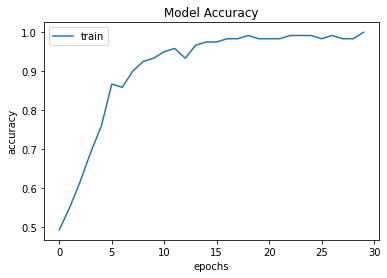

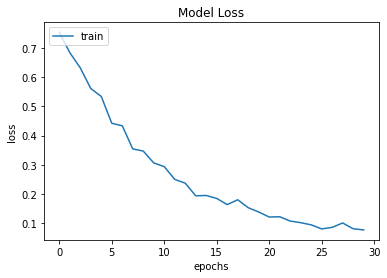

In [20]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    rnn_model = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    seq_model = get_sequence_model()
    seqmodel = seq_model.fit(
        [data_train[0], data_train[1]],
        labels_train,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )
    import matplotlib.pyplot as plt
    plt.plot(seqmodel.history['accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['train'], loc = 'upper left')
    plt.show()
    plt.plot(seqmodel.history['loss'])
    plt.title('Model Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train'], loc = 'upper left')
    plt.show()
    prediction = seq_model.predict(data_test)
    return seq_model, prediction

sequence_model, results = run_experiment()

In [22]:
predict_class = np.argmax(results, axis=1)
predict_class = predict_class.tolist()
pred_text=[]
for i in range(results.shape[0]):
    if predict_class[i] <= 0.5:
        pred_text.append('fire')
    else:
        pred_text.append('not_fire')

image_names=[]
for i in range(test_data.shape[0]):
    image_names.append(test_data['File'][i])

import csv
with open('./test.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(image_names)
    writer.writerow(pred_text)